# Dataset DeepLearning
---

# LIBRERIAS

### Libreria Específicas
---

nibabel
---
Repositorio:
https://nipy.org/nibabel/

Es la librería base en Python para leer, escribir y manipular archivos de neuroimagen médica (NIfTI, Analyze, DICOM, MGH).
- Lee y guarda imágenes NIfTI (.nii y .nii.gz)
- Permite acceder a los datos brutos como arrays NumPy.
- Permite modificar headers, orientaciones, resoluciones, affine matrices.
- Ideal para preprocesamientos bajos o personalizados.

Como se utiliza en este proyecto:
- Toda imagen médica que descargues estará en formato NIfTI.
- Permite convertir imágenes a arrays NumPy para machine learning.
- Es la base sobre la que trabajan nilearn y ANTsPy.
  
ants
---
Repositorio:
https://github.com/ANTsX/ANTsPy

Instalación:
pip install antspyx

Es la versión en Python del famoso software ANTs (Advanced Normalization Tools), desarrollado para el registro espacial y procesamiento avanzado de imágenes médicas, especialmente neuroimagen.
Es una de las librerías más robustas y validadas científicamente en neuroimagen

Permite implementar de manera programática:
- Registro de imágenes (rigido, afín, no lineal SyN).
- Aplicar transformaciones.
- Normalización espacial.
- Operaciones matemáticas sobre imágenes (resampling, smoothing, etc.)
- Extracción de templates.
- Creación de campos de deformación.

Como se utiliza en este proyecto:
- Coregistrar fRMI y RMI.
- Alinear a MNI estándar.
- Transformar máscaras y ROIs entre espacios.
- Estudiar la morfología cerebral.

nilearn
---
Repositorio:
https://nilearn.github.io/

Es una librería de alto nivel pensada para:
- Visualización interactiva de neuroimágenes.
- Machine Learning sobre imágenes cerebrales.
- Extracción de ROIs y máscaras.
- Análisis estadístico de imágenes fMRI.
- Trabajo sencillo con imágenes en espacio MNI.
- Dibuja imágenes cerebrales en 2D y 3D.
- Superpone imágenes funcionales sobre anatómicas.
- Carga y gestiona máscaras, atlas y ROIs.
- Facilita el análisis de series temporales fMRI.
- Prepara datos para machine learning (Matrices feature X target).

Como se utiliza en este proyecto:
- Para visualizar resultados en notebooks.
- Para generar reportes automáticos.
- Para crear datasets a partir de RMI y fRMI procesados.
- Para graficar mapas cerebrales, conectividad y activaciones.



In [1]:
# Librerias específicas de Tratamiento de imágenes RMI y fRMI
import ants  # instalar con pip install antspyx
import nibabel as nib
from nilearn.plotting import plot_anat, plot_epi
import nilearn.plotting as plotting

from nilearn import datasets


In [2]:
# Librerias de Sistema
import subprocess
import os

# Gestión de imágenes y Gráficos
from PIL import Image  
import matplotlib.pyplot as plt
import seaborn as sns

# Pandas
import pandas as pd

# Numpy
import numpy as np

# Librerías Torch
import torch
from torch.utils.data import Dataset, DataLoader,  random_split

import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Librerias de Scikit-Learn
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_auc_score, roc_curve
)


# EDA

## EDA con nilearn y ants
---

In [84]:
# Filtra archivos con extensión .nii.gz
PATH_BASE = './'
archivos_nii = [f for f in os.listdir(PATH_BASE) if f.endswith('.nii.gz')]
for archivo in archivos_nii:
    print(archivo)

sub-1003_ses-wave1_acq-FLAIR_run-1_T2w.nii.gz
sub-1003_ses-wave1_trc-18FAV45_run-1_pet.nii.gz
sub-1003_ses-wave1_task-Hypercapnia_run-1_bold.nii.gz
sub-1003_ses-wave1_acq-ASL_run-1_asl.nii.gz
sub-1003_ses-wave1_acq-DTI_run-1_dwi.nii.gz
mni_template.nii.gz


In [107]:
# Carga de imágenes RMI, fRMI y template MNI
anat_path = 'sub-1003_ses-wave1_acq-FLAIR_run-1_T2w.nii.gz'    # RMI estructural individual
bold_path = 'sub-1003_ses-wave1_trc-18FAV45_run-1_pet.nii.gz'  # fRMI funcional individual
#mni_path = 'mni_template.nii.gz'    # template MNI estándar

anat = ants.image_read(anat_path)
bold = ants.image_read(bold_path)
#mni = ants.image_read(mni_path)
mni = datasets.load_mni152_template(resolution=1)
mni.to_filename(mni_path)
mni = ants.image_read(mni_path)
print(mni_path)
print(mni)  # Ruta local al archivo .nii.gz
print(anat)
print(bold)

mni_template.nii.gz
ANTsImage (LPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (197, 233, 189)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (98.0, 134.0, -72.0)
	 Direction  : [-1.  0.  0.  0. -1.  0.  0.  0.  1.]

ANTsImage (RPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (512, 512, 64)
	 Spacing    : (0.449, 0.449, 2.5)
	 Origin     : (-114.1993, 103.4193, -80.974)
	 Direction  : [ 0.9987  0.0017  0.0508 -0.004  -0.9935  0.1134 -0.0506  0.1135  0.9923]

ANTsImage (RPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (128, 128, 63)
	 Spacing    : (2.5743, 2.5743, 2.425)
	 Origin     : (164.7524, 491.683, -150.35)
	 Direction  : [ 1.  0.  0.  0. -1.  0.  0.  0.  1.]



In [94]:
tx1 = ants.registration(fixed=anat, moving=bold, type_of_transform='Rigid')
bold_reg = tx1['warpedmovout']

In [27]:
tx2 = ants.registration(fixed=mni, moving=anat, type_of_transform='SyN')
anat_reg = tx2['warpedmovout']

In [28]:
bold_mni = ants.apply_transforms(
    fixed=mni, 
    moving=bold, 
    transformlist=tx1['fwdtransforms'] + tx2['fwdtransforms']
)


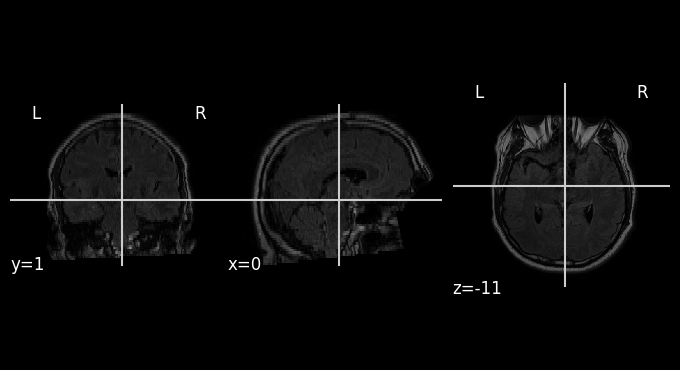

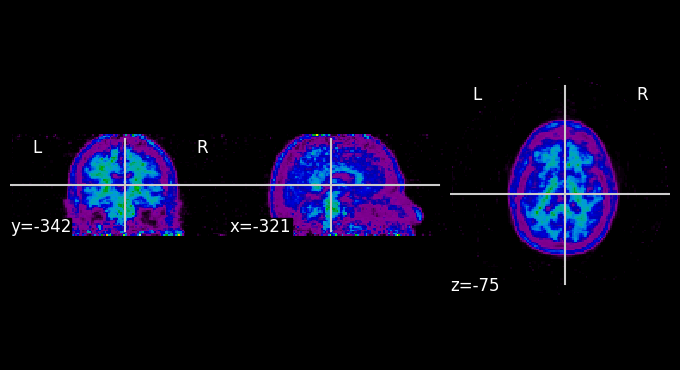

In [33]:
plotting.plot_anat(anat_path)
plotting.plot_epi(bold_path)


In [39]:
def ants_to_nib(img_ants):
    data = img_ants.numpy()
    affine = np.eye(4)
    spacing = img_ants.spacing
    origin = img_ants.origin

    affine[0, 0] = spacing[0]
    affine[1, 1] = spacing[1]
    affine[2, 2] = spacing[2]
    affine[0:3, 3] = origin

    return nib.Nifti1Image(data, affine)

fRMI original (sin registrar):
fRMI registrada a RMI (tx1):


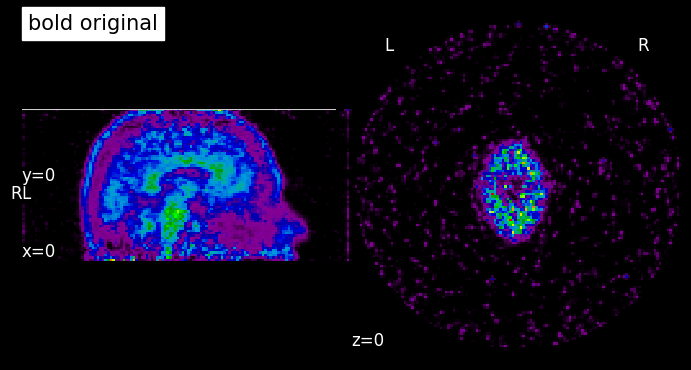

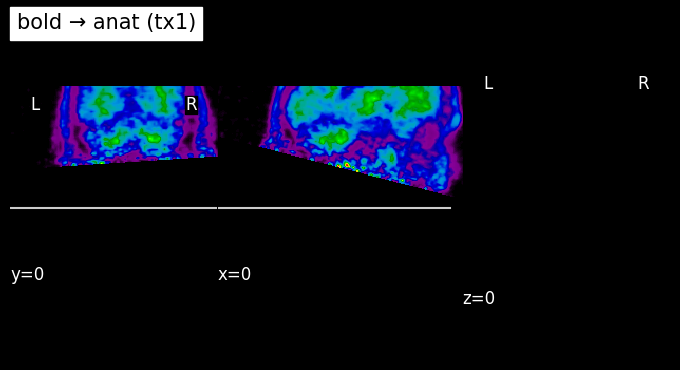

In [42]:
print("fRMI original (sin registrar):")
plot_epi(ants_to_nib(bold), title='bold original', display_mode='ortho', cut_coords=(0, 0, 0))

print("fRMI registrada a RMI (tx1):")
plot_epi(ants_to_nib(bold_mni), title='bold → anat (tx1)', display_mode='ortho', cut_coords=(0, 0, 0))


In [ ]:
# Datos de PArticipantes (features)
# - Cada muestra se identifica con la combinación de S# y 'hoja'
datos_path  ='DatosCompletos.csv'
df_features = pd.read_csv(datos_path)
######################################################
print('Archivo Shell de de gestión de Descargas:\t',  script_path);
print('Path Base Dataset:      t\t\t\t',  DATASET_BASE);
print('Directorio de Descarga:\t\t\t\t',  dataset_path);
print('Número de Muestras:    \t\t\t\t', len(df_features))
print('Valores únicos de hoja:\t\t\t\t', df_features['hoja'].unique())

plt.hist(df_features['target'])
plt.title('Histograma del Target')
plt.show()
         

DWI
---

In [3]:
# Filtra archivos con extensión .nii.gz
PATH_BASE = r"C:\Users\IreEi\Desktop\JUAN&YO\TFM_DEEP_LEARNING_PC\DATA\ds004856-1.2.0\sub-139\ses-wave2\dwi"
archivos_nii = [f for f in os.listdir(PATH_BASE) if f.endswith('.nii.gz')]
for archivo in archivos_nii:
    print(archivo)

sub-139_ses-wave2_acq-DTI_run-1_dwi.nii.gz


In [5]:
dwi_path = "sub-139_ses-wave2_acq-DTI_run-1_dwi.nii.gz"

path = os.path.join(PATH_BASE, dwi_path) 

rmi = ants.image_read("sub-1175_ses-wave3_trc-18FAV45_run-1_pet.nii.gz")
print(rmi)


ANTsImage
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (128, 128, 111, 2)
	 Spacing    : (3.1819, 3.1819, 2.0, 1.0)
	 Origin     : (-203.644, 8.0523, -594.0, 0.0)
	 Direction  : [ 1.  0.  0.  0.  0. -1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.]

